In [652]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

In [653]:
data.shape


(1460, 81)

In [654]:
num_data = data.select_dtypes(include='number')

num_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [655]:
analysis_data = num_data.filter(['GrLivArea', 'SalePrice'], axis=1)
analysis_data

,GrLivArea,SalePrice
0,1710,208500
1,1262,181500
2,1786,223500
3,1717,140000
4,2198,250000
...,...,...
1455,1647,175000
1456,2073,210000
1457,2340,266500
1458,1078,142125


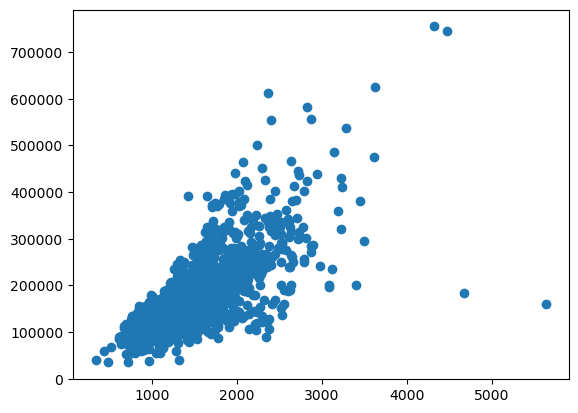

In [656]:
plt.scatter(x=analysis_data.GrLivArea, y=analysis_data.SalePrice)

plt.show()

<Axes: xlabel='GrLivArea'>

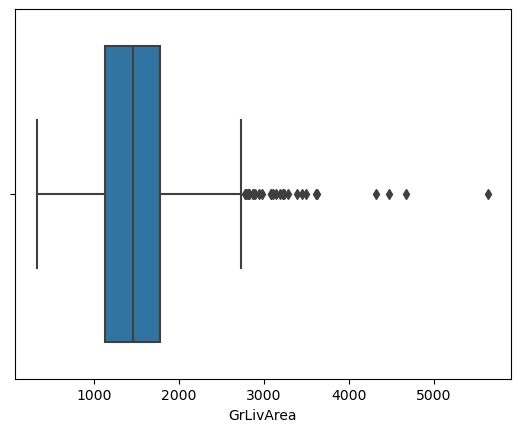

In [657]:
sns.boxplot(x=analysis_data.GrLivArea)


<Axes: ylabel='SalePrice'>

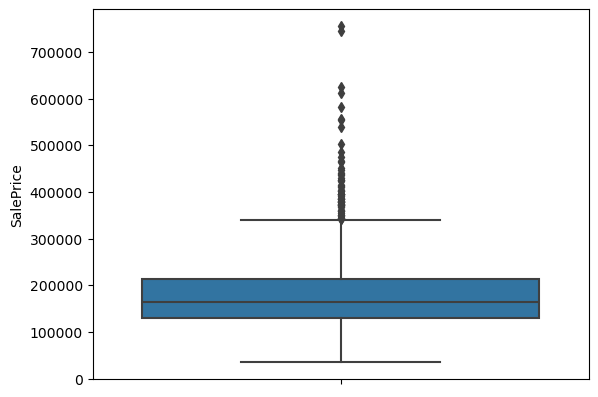

In [658]:
sns.boxplot(y=analysis_data.SalePrice)

In [659]:
z = np.abs(stats.zscore(analysis_data.SalePrice))

print(np.where(z < 2))

(array([   0,    1,    2, ..., 1457, 1458, 1459], dtype=int64),)


In [660]:
def remove_outliers(data: pd.DataFrame, column: str):
    Q1 = np.percentile(column, 25, method='midpoint')
    Q3 = np.percentile(column, 75, method='midpoint')
    
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    upper_array = np.where(column >= upper_bound)[0]
    lower_array = np.where(column <= lower_bound)[0]
    
    new_df = data.drop(index=upper_array, inplace=True)
    new_df = data.drop(index=lower_array, inplace=True)
    
    return new_df

In [661]:
clean = analysis_data[(np.abs(stats.zscore(analysis_data)) < 3).all(axis=1)]


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

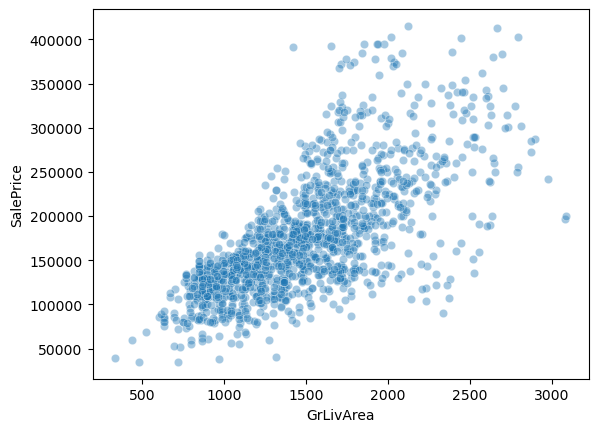

In [662]:
sns.scatterplot(x=clean.GrLivArea, y=clean.SalePrice, alpha=0.4)

<Axes: xlabel='SalePrice', ylabel='Count'>

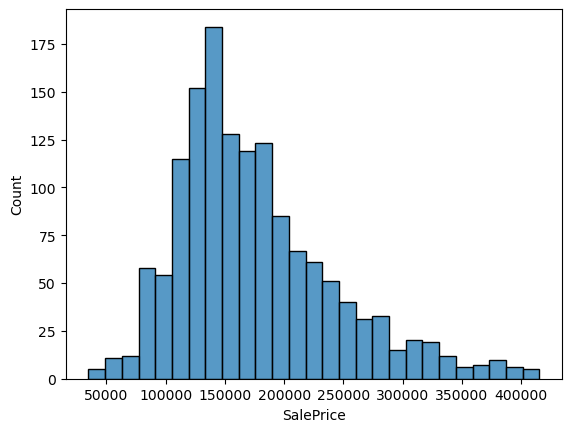

In [663]:
sns.histplot(clean.SalePrice)

<Axes: xlabel='GrLivArea', ylabel='Count'>

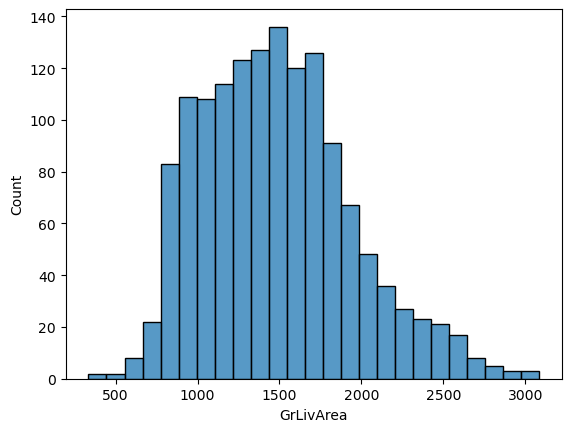

In [664]:
sns.histplot(clean.GrLivArea)

<Axes: >

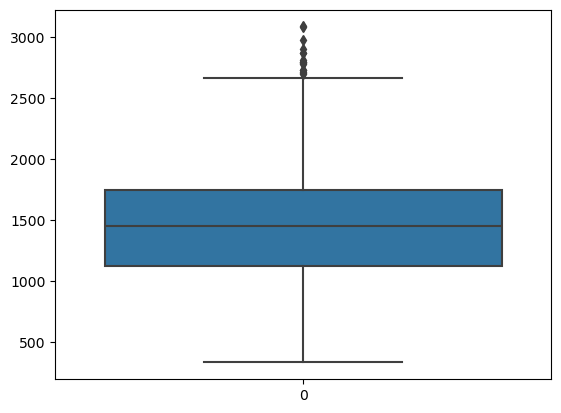

In [665]:
sns.boxplot(clean.GrLivArea)

In [666]:
def z_score_outlier_cleaner(data: pd.DataFrame, z_score_threshold:int, columns_to_keep: [str]) -> pd.DataFrame:
    
    numerical_data = data.select_dtypes(include='number')
    

    z_scores = np.abs(stats.zscore(analysis_data))
    
    
    #z_scores = np.where(z_scores < z_score_threshold)
    
    removed_outliers = numerical_data[(z_scores < z_score_threshold).all(axis=1)]
    
    clean_data = removed_outliers.filter(columns_to_keep, axis=1)
    
    return clean_data
    


In [667]:
cleansed = z_score_outlier_cleaner(data, 3, ['GrLivArea', 'SalePrice'])

cleansed.to_numpy()

array([[  1710, 208500],
       [  1262, 181500],
       [  1786, 223500],
       ...,
       [  2340, 266500],
       [  1078, 142125],
       [  1256, 147500]], dtype=int64)

In [668]:
FloorArea = np.array(cleansed['GrLivArea']).reshape(-1, 1) # cleansed[['GrLivArea']]

SalePrice = np.array(cleansed['SalePrice']).reshape(-1, 1)

Floor_train, Floor_test, Sale_train, Sale_test = train_test_split(FloorArea, SalePrice, test_size=0.2, random_state=None)


Coefficients: 
 [[102.71682632]]
Mean squared error: 2533911499.363069
R2 Score: 0.40325270478050534


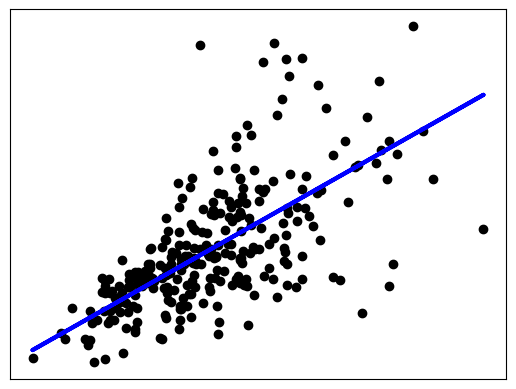

In [669]:
model = linear_model.LinearRegression()

model_fit = model.fit(Floor_train, Sale_train)

model_pred = model.predict(Floor_test)

print(f"Coefficients: \n {model.coef_}")
print(f"Mean squared error: {mean_squared_error(Sale_test, model_pred)}")
print(f"R2 Score: {r2_score(Sale_test, model_pred)}")


plt.scatter(Floor_test, Sale_test, color='black')
plt.plot(Floor_test, model_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Need to get this working, predicted values are playing up

In [670]:
cleansed['predicted_value'] = model.predict(FloorArea)


cleansed['residuals'] = cleansed['SalePrice'] - cleansed['predicted_value'] 

cleansed

,GrLivArea,SalePrice,predicted_value,residuals
0,1710,208500,198553.377403,9946.622597
1,1262,181500,152536.239211,28963.760789
2,1786,223500,206359.856203,17140.143797
3,1717,140000,199272.395187,-59272.395187
4,2198,250000,248679.188648,1320.811352
...,...,...,...,...
1455,1647,175000,192082.217345,-17082.217345
1456,2073,210000,235839.585357,-25839.585357
1457,2340,266500,263264.977985,3235.022015
1458,1078,142125,133636.343168,8488.656832


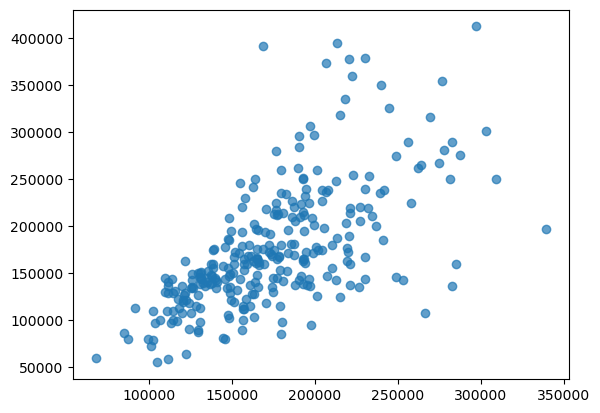

In [679]:
actual_values = Sale_test

plt.scatter(model_pred, actual_values, alpha=0.7)

plt.show()

In [677]:
numerical_data = data.select_dtypes(include='number')

corr = numerical_data.corr()

print(corr['SalePrice'].sort_values(ascending=False)[:10], '\n')

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

